<a href="https://colab.research.google.com/github/yongsimin/W.O.W-Attachment-2022/blob/main/final_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

original version:

https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook

In [1]:
!pip3 install torch torchvision
!pip install pycocotools --quiet
!pip install -U albumentations==0.4.6

     |████████████████████████████████| 117 kB 8.1 MB/s 
     |████████████████████████████████| 948 kB 57.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=7dd77b234a935888cb578781c2535312406f8bbd981ac57ac778bbec43844088
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..

Cloning into 'vision'...
remote: Enumerating objects: 82717, done.
remote: Counting objects: 100% (17849/17849), done.
remote: Compressing objects: 100% (1520/1520), done.
remote: Total 82717 (delta 16421), reused 17511 (delta 16233), pack-reused 64868
Receiving objects: 100% (82717/82717), 161.85 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (69500/69500), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version
/content


In [3]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

# **Generate Training Data** 

*   capture images as square as possible
*   label images with labelImg, with class name: '1', '2', ...
*   multi-class is possible
*   background is a class
*   If num_obj is 3, then num_class is 4
*   modify 'files_dir' and 'test_dir' accordingly

In [ ]:
# as an example, download this training data from (https://github.com/tensorflow/models/tree/master/research/object_detection/test_images/ducky)
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1FAjHVLuzgK41eYGATc8_wQx6vRYhAmPY&export=download
!unzip ducky.zip

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [0/7]  eta: 0:01:28  lr: 0.000017  loss: 2.0317 (2.0317)  loss_classifier: 1.3455 (1.3455)  loss_box_reg: 0.4736 (0.4736)  loss_objectness: 0.1891 (0.1891)  loss_rpn_box_reg: 0.0237 (0.0237)  time: 12.5906  data: 9.3276  max mem: 11281
Epoch: [0]  [6/7]  eta: 0:00:04  lr: 0.000100  loss: 1.4358 (1.5519)  loss_classifier: 0.7255 (0.8745)  loss_box_reg: 0.4736 (0.4863)  loss_objectness: 0.1424 (0.1638)  loss_rpn_box_reg: 0.0248 (0.0273)  time: 4.4894  data: 1.4808  max mem: 11327
Epoch: [0] Total time: 0:00:31 (4.5008 s / it)
creating index...
index created!
Test:  [ 0/21]  eta: 0:00:44  model_time: 0.4989 (0.4989)  evaluator_time: 0.0759 (0.0759)  time: 2.1105  data: 1.5328  max mem: 11327
Test:  [20/21]  eta: 0:00:01  model_time: 0.4683 (0.4702)  evaluator_time: 0.1282 (0.1217)  time: 0.9711  data: 0.3761  max mem: 11327
Test: Total time: 0:00:21 (1.0368 s / it)
Averaged stats: model_time: 0.4683 (0.4702)  evaluator_time: 0.1282 (0.1217)
Accumulating evaluation results...
D

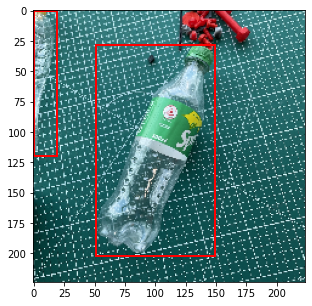

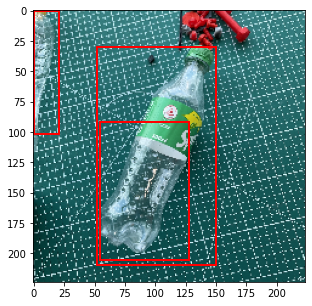

NMS APPLIED MODEL OUTPUT


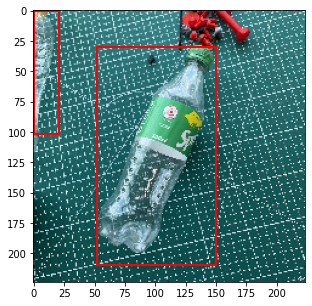

In [1]:
import os
import numpy as np
import cv2
from xml.etree import ElementTree as et
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
# matplotlib.use('tkagg')


files_dir = '/content/images/train'
test_dir = '/content/images/test'
img_size = (224, 224)
num_classes = 4
num_epochs = 100


class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir)) if (image[-4:] =='.JPG') or (image[-4:] =='.jpg')]

        # classes: 0 index is reserved for background
        self.classes = [''] + ['{}'.format(i + 1) for i in range(num_classes)]

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        return img_res, target

    def __len__(self):
        return len(self.imgs)


def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for i, box in enumerate(target['boxes']):
        if target['scores'][i] < 0.5:
            continue
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)
    plt.show()


def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    return final_prediction


def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0].item(), box[1].item(), box[2].item()-box[0].item(), box[3].item()-box[1].item()
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()


def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.VerticalFlip(0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Blur(blur_limit=2, p=0.3),
            A.MotionBlur(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.IAASharpen(p=0.3),
            A.IAAEmboss(p=0.3),
            # ToTensorV2 converts image to pytorch tensor without div by 255
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


if False:
    dataset = ImagesDataset(files_dir, *img_size)
    print('length of dataset = ', len(dataset), '\n')
    img, target = dataset[8]
    print(img.shape, '\n',target)
    img, target = dataset[8]
    plot_img_bbox(img, target)
    exit()

# dataset
dataset = ImagesDataset(files_dir, *img_size, transforms=get_transform(train=True))
dataset_test = ImagesDataset(files_dir, *img_size, transforms=get_transform(train=False))
torch.manual_seed(1)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_object_detection_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//4, gamma=0.1)

# training
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    if epoch % 10 == 0:
      evaluate(model, data_loader_test, device=device)

# saving
torch.save(model.state_dict(), 'ckpt.pth')


img, target = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))
plot_img_bbox(torch_to_pil(img), target)
plot_img_bbox(torch_to_pil(img), prediction)
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

### **After training**

1.   download the ckpt.pth to a local machine
2.   install torch torchvision on the local machine
3.   save the following script on the local machine together with the ckpt.pth
4.   update num_class, img_size, score threshold and ckpt.pth accordingly


In [3]:
!pip3 install torch torchvision

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib
matplotlib.use('tkagg')


def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    return final_prediction


def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for i, box in enumerate(target['boxes']):
        if target['scores'][i] < 0.9:
            continue
        x, y, width, height  = box[0].item(), box[1].item(), box[2].item()-box[0].item(), box[3].item()-box[1].item()
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()


num_classes = 4
img_size = (224, 224)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('/content/ckpt.pth'))
model.to(device)
model.eval()


cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

from PIL import Image
while cap.isOpened():
    _, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size, cv2.INTER_AREA)
    img_res = img.astype(np.float32)
    img_res /= 255.
    img_res = torch.from_numpy(img_res.transpose(2, 0, 1))

    with torch.no_grad():
        prediction = model([img_res.to(device)])[0]
    nms_prediction = apply_nms(prediction, iou_thresh=0.1)
    # plot_img_bbox(torch_to_pil(img), nms_prediction)

    scores = nms_prediction['scores'].cpu().numpy()
    if nms_prediction['scores'].shape[0] > 0:
        mostconfident = np.argmax(scores)
        if scores[mostconfident] > 0.9:
            box = nms_prediction['boxes'][mostconfident]
            x, y, width, height  = box[0].item(), box[1].item(), box[2].item()-box[0].item(), box[3].item()-box[1].item()
            print(x, y, width, height)